# Matthew Peetz
# Regis University
# MSDS 621
# Week 5 Lab: EDA and Visualizations

This week's assignment will be combining many of the concepts from our prior lectures.

Below, I've loaded the immunization dataset from week 3 (nispuf14.csv). You can feel free to use your output from week3 or the verse I have provided in the assign_wk5 folder.

Here is what I've demonstrated below with the immunization dataset.

- separated continuous and categorical columns 
- minimally handled NaNs 
- built a baseline RandomForestClassifier with a random column

I've selected FRSTBRN as my target variable target variable -- not a very interesting column, but it had no missing values. Do not worry, you will have a chance to improve on my work.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Makes graphs prettier
sns.set()      
# Magic command for plots
%matplotlib inline

<div class="alert alert-block alert-warning">
<b>Note::</b> There are a couple of new parameters I'm using with read_csv. I encourage you to go look those up and understand what they do.
</div>

## Load the data

In [2]:
df = pd.read_csv("assign_wk5/nispuf14.csv", na_values=['.'], low_memory=False)

In [3]:
df.head()

SEQNUMC  SEQNUMHH  PDAT             PROVWT_D        PROVWT_D_TERR   
0       11         1     2      .                    .                \
1       21         2     1   806.84601169505000   806.84601169505000   
2       31         3     2      .                    .                 
3       41         4     1    63.44868567610260    63.44868567610260   
4       51         5     1    94.87263225744540    94.87263225744540   

               RDDWT_D  RDDWT_D_TERR  STRATUM  YEAR  AGECPOXR  ...  XVRCTY7   
0   218.30024855484000    218.300249     1022  2014       NaN  ...           \
1   454.86041741251200    454.860417     2036  2014       NaN  ...            
2    30.54542540283290     30.545425     1072  2014       NaN  ...            
3    36.96593137368630     36.965931     2016  2014       NaN  ...            
4    64.62020426239790     64.620204     1073  2014       NaN  ...            

   XVRCTY8  XVRCTY9 INS_1 INS_2 INS_3  INS_3A  INS_4_5  INS_6  INS_11  
0                       .     .     .       .        .      .       .  
1                       2     .     .       2        2      2       .  
2                       .     .     .       .        .      .       .  
3                       1     2     2       .        2      2       2  
4                       2     1     1       .        2      2      77  

[5 rows x 461 columns]

<div class="alert alert-block alert-info">
<b>Pop Quiz::</b> What am I doing in the cell below? 
</div>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24897 entries, 0 to 24896
Columns: 461 entries, SEQNUMC to INS_11
dtypes: float64(220), int64(29), object(212)
memory usage: 87.6+ MB


Answer: All of the various formats that can be numeric are being made numeric, with the call to prevent it from telling you have the cells that can not be changed into numbers not throwing a warning.

In [5]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24897 entries, 0 to 24896
Columns: 461 entries, SEQNUMC to INS_11
dtypes: float64(432), int64(29)
memory usage: 87.6 MB


In [7]:
df.head()

SEQNUMC  SEQNUMHH  PDAT    PROVWT_D  PROVWT_D_TERR     RDDWT_D   
0       11         1     2         NaN            NaN  218.300249  \
1       21         2     1  806.846012     806.846012  454.860417   
2       31         3     2         NaN            NaN   30.545425   
3       41         4     1   63.448686      63.448686   36.965931   
4       51         5     1   94.872632      94.872632   64.620204   

   RDDWT_D_TERR  STRATUM  YEAR  AGECPOXR  ...  XVRCTY7  XVRCTY8  XVRCTY9   
0    218.300249     1022  2014       NaN  ...      NaN      NaN      NaN  \
1    454.860417     2036  2014       NaN  ...      NaN      NaN      NaN   
2     30.545425     1072  2014       NaN  ...      NaN      NaN      NaN   
3     36.965931     2016  2014       NaN  ...      NaN      NaN      NaN   
4     64.620204     1073  2014       NaN  ...      NaN      NaN      NaN   

   INS_1  INS_2  INS_3  INS_3A  INS_4_5  INS_6  INS_11  
0    NaN    NaN    NaN     NaN      NaN    NaN     NaN  
1    2.0    NaN    NaN     2.0      2.0    2.0     NaN  
2    NaN    NaN    NaN     NaN      NaN    NaN     NaN  
3    1.0    2.0    2.0     NaN      2.0    2.0     2.0  
4    2.0    1.0    1.0     NaN      2.0    2.0    77.0  

[5 rows x 461 columns]

I like to make a copy of my dataset before I start manipulating the data. This is a personal preference.

In [8]:
df_copy = df.copy()

In [9]:
!pip install PyPDF2

Defaulting to user installation because normal site-packages is not writeable


## Seperate Categorical vs Continuous Variables

In [10]:
from PyPDF2 import PdfReader
#from PyPdf2.pdf import Destination  # read the pdf file

In [11]:
pdf_file = 'assign_wk5/NISPUF14_CODEBOOK.PDF'

In [12]:
reader = PdfReader(pdf_file)
outlines = reader.outline

I notice the PDF's outline tells us which variables are continuous. I would like to be able to read that outline and get those variables. Unfortunately, the PDF outline format is not terribly conducive to this operation.

<img src="figures_wk5/pdf_continuous.png" width=800><br>

As you can see, in the outlne "tree", when we see the text "Continuous Statistics", we need the **previous** entry, but PDF outlines are weird mixes of dictionaries and lists. I finally found the following answer on StackOverflow that satisfied the need. 

From https://stackoverflow.com/questions/1011938/python-previous-and-next-values-inside-a-loop

In [13]:
from itertools import tee, islice, chain

def previous_and_next(some_iterable):
    prevs, items, nexts = tee(some_iterable, 3)
    prevs = chain([None], prevs)
    nexts = chain(islice(nexts, 1, None), [None])
    return zip(prevs, items, nexts)

Testing if I could find the word "Contnuous" in the PDF outline.

In [14]:
'Continuous' in outlines[7][0].title

True

In [15]:
cont_list = []
for prev, item, nxt in previous_and_next(outlines):
    if isinstance(item, list) :
        if 'Continuous' in str(item[0].title):
            cont_list.append(prev.title)

In [16]:
cont_list[:5]

['PROVWT_D', 'PROVWT_D_TERR', 'RDDWT_D', 'RDDWT_D_TERR', 'BF_ENDR06']

In [17]:
cat_list = [c for c in df_copy.columns if c not in cont_list]

## Cleaning up the Missing Values 

I'm not going to do a lot to handle the missing values in this demo.  **However**, I will expect you to do more than I do.

I'll simply: 
* for categories, fill with -999 <br>
* for continuous, fill with mean

In [18]:
for col in cat_list:
    df_copy[col].fillna(-999, inplace=True)

In [19]:
for col in cont_list:
    df_copy[col].fillna(df[col].mean(), inplace=True)

In [20]:
df_copy.head()

SEQNUMC  SEQNUMHH  PDAT    PROVWT_D  PROVWT_D_TERR     RDDWT_D   
0       11         1     2  383.438950     382.821312  218.300249  \
1       21         2     1  806.846012     806.846012  454.860417   
2       31         3     2  383.438950     382.821312   30.545425   
3       41         4     1   63.448686      63.448686   36.965931   
4       51         5     1   94.872632      94.872632   64.620204   

   RDDWT_D_TERR  STRATUM  YEAR  AGECPOXR  ...  XVRCTY7  XVRCTY8  XVRCTY9   
0    218.300249     1022  2014    -999.0  ...   -999.0   -999.0   -999.0  \
1    454.860417     2036  2014    -999.0  ...   -999.0   -999.0   -999.0   
2     30.545425     1072  2014    -999.0  ...   -999.0   -999.0   -999.0   
3     36.965931     2016  2014    -999.0  ...   -999.0   -999.0   -999.0   
4     64.620204     1073  2014    -999.0  ...   -999.0   -999.0   -999.0   

   INS_1  INS_2  INS_3  INS_3A  INS_4_5  INS_6  INS_11  
0 -999.0 -999.0 -999.0  -999.0   -999.0 -999.0  -999.0  
1    2.0 -999.0 -999.0     2.0      2.0    2.0  -999.0  
2 -999.0 -999.0 -999.0  -999.0   -999.0 -999.0  -999.0  
3    1.0    2.0    2.0  -999.0      2.0    2.0     2.0  
4    2.0    1.0    1.0  -999.0      2.0    2.0    77.0  

[5 rows x 461 columns]

## Random Forest Classifier Benchmark

My target is going to be FRSTBRN -- FIRST BORN STATUS OF CHILD.

FRSTBRN is a categorical variable (1 - No, 2 - Yes), so I will use the classifier version of RandomForest. If your target variable is continuous, you will need to use the regressor version of this algorithm.

Take a look at: <br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html <br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

<div class="alert alert-block alert-info">
<b>Pop Quiz::</b> Do you know what the following does? 
</div>

Answer: The computer uses a random seed for splitting the test and train set. This means that each time the program is run a different set is created. If we want to be able to replicated our results the seed mus be set. Which number should be used. 42, of course. 

See Hitch Hikers Guide to the Galaxy, Douglas Adams

In [22]:
np.random.seed(42)

In [23]:
y = df_copy['FRSTBRN']
X = df_copy.drop('FRSTBRN', axis=1)

I'm going to get the min and max values from one of the continuous variables to use as the min/max for the random column. 

In [24]:
the_min = X.PROVWT_D.min()
the_max = X.PROVWT_D.max()
X['random'] = np.random.normal(the_min, the_max, size=X.shape[0])

In [25]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [26]:
clf=RandomForestClassifier(n_estimators=100)

In [27]:
clf.fit(x_train,y_train)

RandomForestClassifier()

I'm going to check the accuracy of my model. Ultimately we want to use this model to help us learn something about our data. So, if our model's accuracy is low, then our "learning" with have a low level of confidence too.

In [28]:
y_pred=clf.predict(x_test)

In [29]:
from sklearn import metrics

In [30]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) 

Accuracy: 0.8832663989290496


A model with a 88% accuracy is really good. One technique you can use to increase your accuracy is scale/normalize your data. The reasoning behind this is that algorithms like Random Forest tend to "favor" columns with a large range of values. Scaling/Normalizing your data will reduce this bias effect in your algorithm.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html

### Feature Selection: Random Number Trick

In [31]:
features = x_train.columns
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


feature_rank = []
# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    feature = f"{f + 1}. feature {features[indices[f]]}   \t{importances[indices[f]] * 100 :.2f}%"
    if 'random' in features[indices[f]]:
        feature += " <=="
    print(feature)
    feature_rank.append([features[indices[f]], importances[indices[f]]] )



Feature ranking:
1. feature CHILDNM   	27.04%
2. feature C1R   	15.07%
3. feature random   	1.72% <==
4. feature SEQNUMC   	1.61%
5. feature RDDWT_D_TERR   	1.59%
6. feature SEQNUMHH   	1.58%
7. feature RDDWT_D   	1.53%
8. feature STRATUM   	1.46%
9. feature INCPORAR   	1.41%
10. feature M_AGEGRP   	1.32%
11. feature BF_ENDR06   	1.27%
12. feature EST_GRANT   	1.27%
13. feature ESTIAP14   	1.24%
14. feature STATE   	1.18%
15. feature BF_FORMR08   	1.06%
16. feature INCQ298A   	1.02%
17. feature BF_EXCLR06   	0.99%
18. feature NUM_CELLS_HH   	0.74%
19. feature AGEGRP   	0.70%
20. feature EDUC1   	0.66%
21. feature D6R   	0.61%
22. feature PROVWT_D   	0.60%
23. feature PROVWT_D_TERR   	0.58%
24. feature INCPOV1   	0.58%
25. feature C5R   	0.56%
26. feature DDTP4   	0.51%
27. feature CEN_REG   	0.51%
28. feature INTRP   	0.50%
29. feature DVRC1   	0.49%
30. feature NUM_CELLS_PARENTS   	0.49%
31. feature DHEPB2   	0.48%
32. feature DHIB3   	0.48%
33. feature DDTP3   	0.48%
34. feature DFLU

Hmmm... Our random number turns out to be the third most important feature for my target variable of FRSTBRN.  

So my FRSTBRN investigation shows the top 2 variables for determining whether a child is firstborn are:
    * CHILDNM -- Number of children in the household, and
    * C1R  -- Number of people in the household.

That's kindda sad! 

Lesson of the day, choose your variables wisely.

# Assignment Requirements

Now it's your turn to perform a similar type of analysis. 

Using the immunization dataset, complete the following: <br>
1) Load the dataset and cleanup the missing values.
   - As noted above, you need to do more than I did in my demonstration.
   - Defend your handling of these values. 
       * Tell me why are you doing what you are doing to the data, it matters!
2) Choose your own target variable (can be categorical or continuous, if you feel brave)
3) Determine if any of the variables are correlated to each other.
   - Produce a correlation matrix at a minimum.  
   - If you decide to do a pairplot, remember the warning about wide datasets.
   - Use the Random Number Trick to determine relevant variables.   
       * Remember to check the accuracy of your model, before making any decisions.
          - If your accuracy is under 85%, you should improve your model or slect a new target variable.
4) Reduce the dataset to only include correlated variables from above.
5) Complete EDA using the lecture notebook as a baseline -- feel free to add your own tests.
    * Produce visualizations for each of your remaining columns.
    * Explain what your visuals are telling you about your data. Be specific!  
6) Based on EDA results, either
    * Go back for more variables, or
    * Drop more variables
7) Summary/conclude of your findings. Be specific and detailed in your explanations.
    * What do all the visuals mean in your analysis?
    * Why did you handling the data the way you did?
    * Don't assume I'll understand based on your code.    

# Deliverables

## 1) Load the dataset and cleanup the missing values.
   - As noted above, you need to do more than I did in my demonstration.
   - Defend your handling of these values. 
       * Tell me why are you doing what you are doing to the data, it matters!

In [32]:
# Loading the dataset
df = pd.read_csv("assign_wk5/nispuf14.csv", na_values=['.'], low_memory=False)

In [33]:
# Taking a look at the dataset
df.head()

SEQNUMC  SEQNUMHH  PDAT             PROVWT_D        PROVWT_D_TERR   
0       11         1     2      .                    .                \
1       21         2     1   806.84601169505000   806.84601169505000   
2       31         3     2      .                    .                 
3       41         4     1    63.44868567610260    63.44868567610260   
4       51         5     1    94.87263225744540    94.87263225744540   

               RDDWT_D  RDDWT_D_TERR  STRATUM  YEAR  AGECPOXR  ...  XVRCTY7   
0   218.30024855484000    218.300249     1022  2014       NaN  ...           \
1   454.86041741251200    454.860417     2036  2014       NaN  ...            
2    30.54542540283290     30.545425     1072  2014       NaN  ...            
3    36.96593137368630     36.965931     2016  2014       NaN  ...            
4    64.62020426239790     64.620204     1073  2014       NaN  ...            

   XVRCTY8  XVRCTY9 INS_1 INS_2 INS_3  INS_3A  INS_4_5  INS_6  INS_11  
0                       .     .     .       .        .      .       .  
1                       2     .     .       2        2      2       .  
2                       .     .     .       .        .      .       .  
3                       1     2     2       .        2      2       2  
4                       2     1     1       .        2      2      77  

[5 rows x 461 columns]

As was demonstrated above, a lot of things, like age, are being stored in object form. I am going to go ahead and change these to numbers.

In [34]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [35]:
# Making a copy of the data frame
df_new = df

After looking at a lot of the data, and trying other methods, filling the continous values with the mean is probably the lesser of all the evils. A lot of the missing data is things like weight of child, and there is just not a good way to impute it any other way. There are 122 continous variables, if you had all the time in the world you could come up with an individual solution for each, like imputing weight based on the average of that age catagory. This may give you a cleaner result. 

One thing that I did notice is that the number of values missing in a lot of the rows is the same. After reading through the report I found the following:

<img align="right" style="padding-right:100px;" src="figures_wk5/image_1.png" width=1000><br>

To start, I want to limit the rows to only those that have "Adequate Provider Data" I am going to do that using the code below.

In [36]:
# Picked a random column that has 15,059 from the vaccine info.
df_adequate = df.dropna(subset=['P_NUHEPX'])

In [ ]:
df_adequate.info(verbose=True, show_counts=True)

It is going to be helpful to separate the values into catagorical values AND continous values. As such I am going to use the code that was shown above to kick off dealing with the missing values.

In [38]:
# Using the code from the example to split the data into continous and categorical groups to fill in the NA values

from itertools import tee, islice, chain

def previous_and_next(some_iterable):
    prevs, items, nexts = tee(some_iterable, 3)
    prevs = chain([None], prevs)
    nexts = chain(islice(nexts, 1, None), [None])
    return zip(prevs, items, nexts)

cont_list = []
for prev, item, nxt in previous_and_next(outlines):
    if isinstance(item, list) :
        if 'Continuous' in str(item[0].title):
            cont_list.append(prev.title)
            
cont_list[:5]

cat_list = [c for c in df_adequate.columns if c not in cont_list]
            

Catagorical values are going to get a 0, that way I can later use the column as a catagory and just know that 0 means "Unknown" or missing.

In [ ]:
for col in cat_list:
    df_adequate[col].fillna(0, inplace=True)

In [40]:
df_adequate.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 15059 entries, 1 to 24896
Data columns (total 461 columns):
 #    Column               Non-Null Count  Dtype  
---   ------               --------------  -----  
 0    SEQNUMC              15059 non-null  int64  
 1    SEQNUMHH             15059 non-null  int64  
 2    PDAT                 15059 non-null  int64  
 3    PROVWT_D             14893 non-null  float64
 4    PROVWT_D_TERR        15059 non-null  float64
 5    RDDWT_D              14893 non-null  float64
 6    RDDWT_D_TERR         15059 non-null  float64
 7    STRATUM              15059 non-null  int64  
 8    YEAR                 15059 non-null  int64  
 9    AGECPOXR             15059 non-null  float64
 10   HAD_CPOX             15059 non-null  int64  
 11   SHOTCARD             15059 non-null  int64  
 12   AGEGRP               15059 non-null  int64  
 13   BF_ENDR06            11724 non-null  float64
 14   BF_EXCLR06           12100 non-null  float64
 15   BF_FORMR08           1

# Making some progress!! Columns that still have missing information:
* 3 this is child weight
* 5 this is child weight, but from a different source and time
* 13,14,15 are information on breastfeeding, going to be impossible to fill this with anything other than "unknown"
* 18 this is census region, some if just missing, it could be imputed from other geographic data
* 26 this is income to poverty ratio
* 34 the number of landlines in the home, more than 50% of that data it missing

It is going to be impossible to fill in things like the child's breastfeeding habit, so this information either needs a dummy value or to be removed from the data set. Same with the child's weight. You can not impute it based on age, as kids very so much in size. You could use a mean for those values, but that will be less than ideal as well. This is where cleaning up data is so much effort. I do not want to toss out any more data, I already am taking just the "Adequate" information from the data and have filled in a lot of the categorical information with "Unknown". At this point the lesser of evils is to fill in the continous data with the mean of the column.

In [41]:
# Looking at a column with a lot of missing continous data
df_adequate['DFLU3']

1         421.0
3         553.0
4        1099.0
5           NaN
6           NaN
          ...  
24889       NaN
24890       NaN
24891     756.0
24895       NaN
24896       NaN
Name: DFLU3, Length: 15059, dtype: float64

In [42]:
df_full = df_adequate.fillna(df_adequate.mean())

Checking to see if there are still any missing values

In [43]:
df_full.isnull().values.any()

False

## 2) Choose your own target variable (can be categorical or continuous, if you feel brave)
#### I am curious to look at chicken pox infections, data is stored as either a 1 - child had chicken pox, a 2 - child never had chicken pox, or 77, unknown, or 99 missing.

In [44]:
df_pox = df_full

In [45]:
# Looking at the unique values in the "had chicken pox" column
df_pox['HAD_CPOX'].unique()

array([ 2,  1, 77], dtype=int64)

According to the code book "77" means "Unknown" if child had chicken pox, those are going to need to be dropped for our classifier.

In [46]:
df_pox = df_pox[df_pox.HAD_CPOX != 77]

In [47]:
# Looking at the unique values in the "had chicken pox" column
df_pox['HAD_CPOX'].unique()

array([2, 1], dtype=int64)

# 3) Determine if any of the variables are correlated to each other.
   - Produce a correlation matrix at a minimum.  
   - If you decide to do a pairplot, remember the warning about wide datasets.
   - Use the Random Number Trick to determine relevant variables.   
       * Remember to check the accuracy of your model, before making any decisions.
          - If your accuracy is under 85%, you should improve your model or slect a new target variable.

#### Producing a correlation matrix
This is going to be a little bit of a challenge, considering there are 233 features. It is just going to be really large and hard to tell what is correlated or not. Below is a correlation matrix with all the data.

<Axes: >

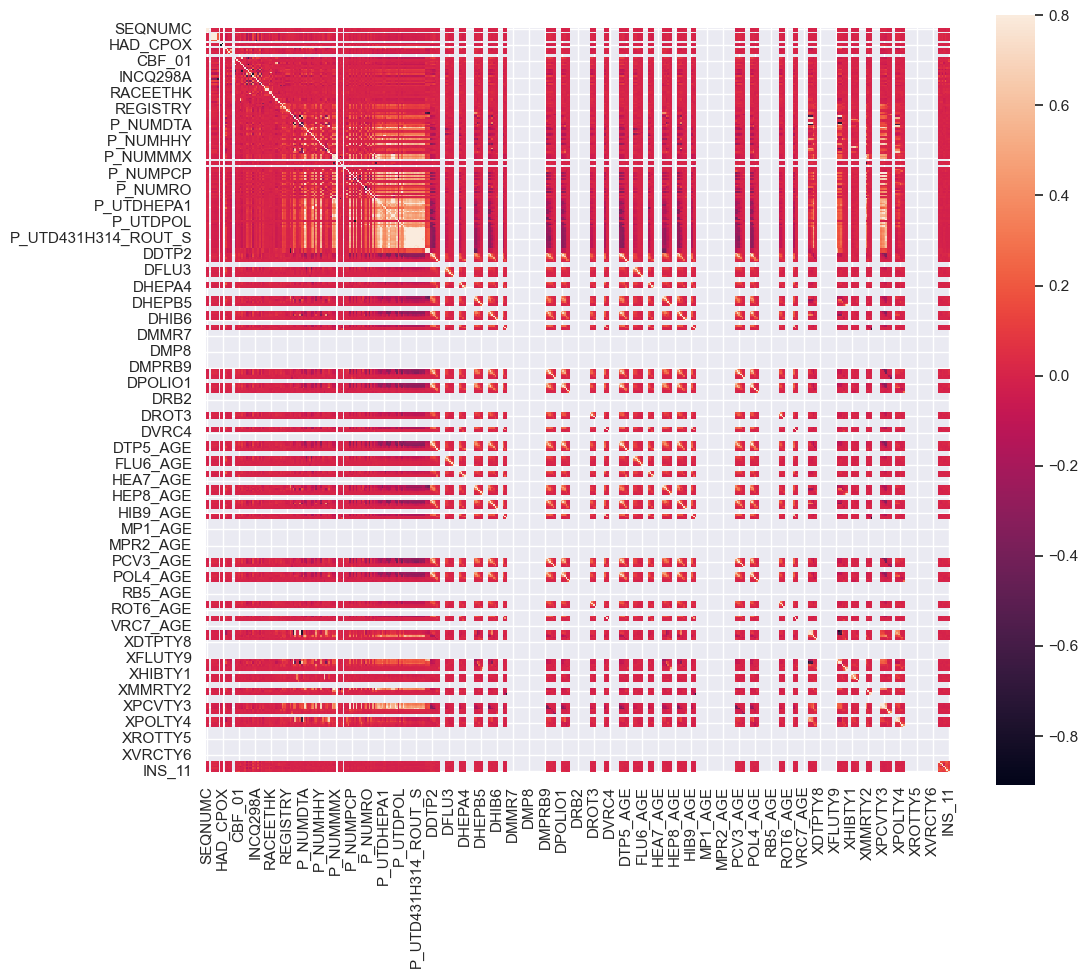

In [48]:
corrmat = df_pox.corr()
f, ax = plt.subplots(figsize=(12,10)) #setting some parameters of the plot to help readability
sns.heatmap(corrmat, vmax = .8, square=True)

It is going to be necessary to first pair down the features. This will be done following the method in the lecture material of creating a random number to use as a feature, and then selecting only features that perform better than the random number.

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

y = df_pox.HAD_CPOX
x = df_pox.drop(['HAD_CPOX'], axis=1)

In [50]:
# Creating the random number
np.random.seed(42)
x['random'] = np.random.normal(0.0, 1.0, size=x.shape[0])

C:\Users\matth\AppData\Local\Temp\ipykernel_18632\1480610971.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  x['random'] = np.random.normal(0.0, 1.0, size=x.shape[0])


In [51]:
# Checking that the random number was added
x.head(10)

SEQNUMC  SEQNUMHH  PDAT     PROVWT_D  PROVWT_D_TERR     RDDWT_D   
1        21         2     1   806.846012     806.846012  454.860417  \
3        41         4     1    63.448686      63.448686   36.965931   
4        51         5     1    94.872632      94.872632   64.620204   
5        52         5     1   152.273845     152.273845   85.219413   
6        61         6     1   210.186351     210.186351  112.170514   
7        71         7     1   204.953336     204.953336  142.607339   
8        81         8     1  1016.753531    1016.753531  499.775831   
11      111        11     1   390.532585     390.532585  177.088881   
12      121        12     1   248.745510     248.745510  171.865720   
13      131        13     1   489.064864     489.064864  396.329703   

    RDDWT_D_TERR  STRATUM  YEAR  AGECPOXR  ...  XVRCTY8  XVRCTY9  INS_1   
1     454.860417     2036  2014       0.0  ...      0.0      0.0    2.0  \
3      36.965931     2016  2014       0.0  ...      0.0      0.0    1.0   
4      64.620204     1073  2014       0.0  ...      0.0      0.0    2.0   
5      85.219413     1073  2014       0.0  ...      0.0      0.0    2.0   
6     112.170514     1057  2014       0.0  ...      0.0      0.0    2.0   
7     142.607339     2002  2014       0.0  ...      0.0      0.0    1.0   
8     499.775831     1022  2014       0.0  ...      0.0      0.0    1.0   
11    177.088881     2047  2014       0.0  ...      0.0      0.0    2.0   
12    171.865720     2016  2014       0.0  ...      0.0      0.0    2.0   
13    396.329703     2025  2014       0.0  ...      0.0      0.0    2.0   

    INS_2  INS_3  INS_3A  INS_4_5  INS_6  INS_11    random  
1     0.0    0.0     2.0      2.0    2.0     0.0  0.496714  
3     2.0    2.0     0.0      2.0    2.0     2.0 -0.138264  
4     1.0    1.0     0.0      2.0    2.0    77.0  0.647689  
5     1.0    1.0     0.0      2.0    2.0     1.0  1.523030  
6     0.0    0.0     1.0      2.0    2.0     2.0 -0.234153  
7     2.0    2.0     0.0      2.0    2.0     2.0 -0.234137  
8     0.0    0.0     2.0      2.0    2.0     2.0  1.579213  
11    0.0    0.0     1.0      2.0    2.0    77.0  0.767435  
12    1.0    2.0     0.0      2.0    2.0     2.0 -0.469474  
13    1.0    2.0     0.0      2.0    2.0     2.0  0.542560  

[10 rows x 461 columns]

In [52]:
# Creating a 70/30 train test split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

clf=RandomForestClassifier(n_estimators=100)
clf.fit(x_train,y_train)

RandomForestClassifier()

In [53]:
# Running the random forest
features = x_train.columns
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Save the feature ranking to a list for later use
# and print it on the screen

feature_rank = []
print("Feature ranking:")

for f in range(x_train.shape[1]):
    feature = f"{f + 1}. feature {features[indices[f]]}   \t{importances[indices[f]] * 100 :.2f}%"
    if 'random' in features[indices[f]]:
        feature += " <=="
    print(feature)
    feature_rank.append([features[indices[f]], importances[indices[f]]] )

Feature ranking:
1. feature AGECPOXR   	39.53%
2. feature SEQNUMC   	1.00%
3. feature SEQNUMHH   	0.98%
4. feature random   	0.97% <==
5. feature STRATUM   	0.93%
6. feature BF_ENDR06   	0.85%
7. feature PROVWT_D   	0.83%
8. feature PROVWT_D_TERR   	0.80%
9. feature EST_GRANT   	0.78%
10. feature DDTP4   	0.78%
11. feature RDDWT_D_TERR   	0.76%
12. feature DFLU1   	0.73%
13. feature ESTIAP14   	0.71%
14. feature DDTP2   	0.69%
15. feature BF_FORMR08   	0.69%
16. feature DHEPB2   	0.67%
17. feature DHIB1   	0.65%
18. feature DHEPA2   	0.64%
19. feature RDDWT_D   	0.63%
20. feature DPCV1   	0.63%
21. feature DVRC1   	0.62%
22. feature DPCV4   	0.62%
23. feature DPCV2   	0.62%
24. feature DDTP1   	0.62%
25. feature BF_EXCLR06   	0.61%
26. feature DHIB3   	0.61%
27. feature STATE   	0.60%
28. feature DHIB2   	0.60%
29. feature NUM_CELLS_HH   	0.60%
30. feature DPCV3   	0.59%
31. feature DDTP3   	0.59%
32. feature DPOLIO3   	0.59%
33. feature INCPORAR   	0.57%
34. feature DROT3   	0.55%
35.

Yikes!!! That is not good, there is only a single feature, Age at which child had chicken pox, that is a better indicator of if a child has had chicken pox, then a random number. That is just not going to work well for building a model. Lets try another possibility, Rent or Owning a home.

In [54]:
df_rentown = df_full

In [55]:
# Unique values in Rent or Own
df_rentown['RENT_OWN'].unique()

array([ 2,  1,  3, 99, 77], dtype=int64)

The values in Rent / Own are either: 1 own (or buying) , 2 renting, 3 (other arangement 3% of the data), or missing / unknown. I am going to drop anything other than 1 or 2.

In [56]:
df_rentown = df_rentown[df_rentown.RENT_OWN != 3]
df_rentown = df_rentown[df_rentown.RENT_OWN != 77]
df_rentown = df_rentown[df_rentown.RENT_OWN != 99]

In [57]:
# Unique values in Rent or Own
df_rentown['RENT_OWN'].unique()

array([2, 1], dtype=int64)

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

y = df_rentown.RENT_OWN
x = df_rentown.drop(['RENT_OWN'], axis=1)

In [59]:
# Creating the random number
np.random.seed(42)
x['random'] = np.random.normal(0.0, 1.0, size=x.shape[0])

C:\Users\matth\AppData\Local\Temp\ipykernel_18632\1480610971.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  x['random'] = np.random.normal(0.0, 1.0, size=x.shape[0])


In [60]:
# Checking that the random number was added
x.head(10)

SEQNUMC  SEQNUMHH  PDAT     PROVWT_D  PROVWT_D_TERR     RDDWT_D   
1        21         2     1   806.846012     806.846012  454.860417  \
3        41         4     1    63.448686      63.448686   36.965931   
4        51         5     1    94.872632      94.872632   64.620204   
5        52         5     1   152.273845     152.273845   85.219413   
6        61         6     1   210.186351     210.186351  112.170514   
7        71         7     1   204.953336     204.953336  142.607339   
8        81         8     1  1016.753531    1016.753531  499.775831   
11      111        11     1   390.532585     390.532585  177.088881   
12      121        12     1   248.745510     248.745510  171.865720   
13      131        13     1   489.064864     489.064864  396.329703   

    RDDWT_D_TERR  STRATUM  YEAR  AGECPOXR  ...  XVRCTY8  XVRCTY9  INS_1   
1     454.860417     2036  2014       0.0  ...      0.0      0.0    2.0  \
3      36.965931     2016  2014       0.0  ...      0.0      0.0    1.0   
4      64.620204     1073  2014       0.0  ...      0.0      0.0    2.0   
5      85.219413     1073  2014       0.0  ...      0.0      0.0    2.0   
6     112.170514     1057  2014       0.0  ...      0.0      0.0    2.0   
7     142.607339     2002  2014       0.0  ...      0.0      0.0    1.0   
8     499.775831     1022  2014       0.0  ...      0.0      0.0    1.0   
11    177.088881     2047  2014       0.0  ...      0.0      0.0    2.0   
12    171.865720     2016  2014       0.0  ...      0.0      0.0    2.0   
13    396.329703     2025  2014       0.0  ...      0.0      0.0    2.0   

    INS_2  INS_3  INS_3A  INS_4_5  INS_6  INS_11    random  
1     0.0    0.0     2.0      2.0    2.0     0.0  0.496714  
3     2.0    2.0     0.0      2.0    2.0     2.0 -0.138264  
4     1.0    1.0     0.0      2.0    2.0    77.0  0.647689  
5     1.0    1.0     0.0      2.0    2.0     1.0  1.523030  
6     0.0    0.0     1.0      2.0    2.0     2.0 -0.234153  
7     2.0    2.0     0.0      2.0    2.0     2.0 -0.234137  
8     0.0    0.0     2.0      2.0    2.0     2.0  1.579213  
11    0.0    0.0     1.0      2.0    2.0    77.0  0.767435  
12    1.0    2.0     0.0      2.0    2.0     2.0 -0.469474  
13    1.0    2.0     0.0      2.0    2.0     2.0  0.542560  

[10 rows x 461 columns]

In [61]:
# Creating a 70/30 train test split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

clf=RandomForestClassifier(n_estimators=100)
clf.fit(x_train,y_train)

RandomForestClassifier()

In [62]:
# Running the random forest
features = x_train.columns
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Save the feature ranking to a list for later use
# and print it on the screen

feature_rank = []
print("Feature ranking:")

for f in range(x_train.shape[1]):
    feature = f"{f + 1}. feature {features[indices[f]]}   \t{importances[indices[f]] * 100 :.2f}%"
    if 'random' in features[indices[f]]:
        feature += " <=="
    print(feature)
    feature_rank.append([features[indices[f]], importances[indices[f]]] )

Feature ranking:
1. feature INCQ298A   	3.91%
2. feature INCPORAR   	3.56%
3. feature CWIC_02   	2.87%
4. feature CWIC_01   	2.32%
5. feature INS_1   	2.04%
6. feature INCPOV1   	1.99%
7. feature RDDWT_D   	1.55%
8. feature PROVWT_D_TERR   	1.54%
9. feature INTRP   	1.51%
10. feature PROVWT_D   	1.46%
11. feature RDDWT_D_TERR   	1.41%
12. feature STRATUM   	1.40%
13. feature EDUC1   	1.37%
14. feature SEQNUMC   	1.22%
15. feature random   	1.21% <==
16. feature MARITAL2   	1.20%
17. feature NUM_CELLS_HH   	1.18%
18. feature SEQNUMHH   	1.11%
19. feature ESTIAP14   	1.11%
20. feature EST_GRANT   	1.09%
21. feature STATE   	1.04%
22. feature DPCV3   	1.02%
23. feature DDTP4   	0.97%
24. feature DHIB3   	0.97%
25. feature DDTP3   	0.96%
26. feature DHEPB3   	0.96%
27. feature DPOLIO3   	0.96%
28. feature DMMR1   	0.96%
29. feature DPCV4   	0.95%
30. feature BF_ENDR06   	0.95%
31. feature DVRC1   	0.94%
32. feature DHEPB2   	0.92%
33. feature DFLU1   	0.92%
34. feature DHEPA1   	0.92%
35. 

That looks much better! There are 14 features that are better than a random number. Those are going to be pulled out.

In [63]:
top_ranks = feature_rank[:14]
top_ranks

[['INCQ298A', 0.0391078205871675],
 ['INCPORAR', 0.035646692927725536],
 ['CWIC_02', 0.028654993902786093],
 ['CWIC_01', 0.023230175100834492],
 ['INS_1', 0.02038651884983103],
 ['INCPOV1', 0.01993765656568219],
 ['RDDWT_D', 0.015504673576702621],
 ['PROVWT_D_TERR', 0.015420602721063194],
 ['INTRP', 0.015110562235401708],
 ['PROVWT_D', 0.014569486403276415],
 ['RDDWT_D_TERR', 0.014149759071087026],
 ['STRATUM', 0.014039891742704431],
 ['EDUC1', 0.013715384235440805],
 ['SEQNUMC', 0.012218604653439855]]

Creating a dataset with just those features AND the target, Rent Own

In [64]:
top_rank_cols = [s[0].split(',')[0] for s in top_ranks]
top_rank_cols.append('RENT_OWN')
top_rank_cols

['INCQ298A',
 'INCPORAR',
 'CWIC_02',
 'CWIC_01',
 'INS_1',
 'INCPOV1',
 'RDDWT_D',
 'PROVWT_D_TERR',
 'INTRP',
 'PROVWT_D',
 'RDDWT_D_TERR',
 'STRATUM',
 'EDUC1',
 'SEQNUMC',
 'RENT_OWN']

In [65]:
# Creating a clean copy of the dataset to prevent messing with the OG set
top_rank_df = df_rentown[top_rank_cols].copy()

In [66]:
top_rank_df.head(10)

INCQ298A  INCPORAR  CWIC_02  CWIC_01  INS_1  INCPOV1     RDDWT_D   
1          4  0.500000      0.0        2    2.0        3  454.860417  \
3         14  3.000000      0.0        2    1.0        1   36.965931   
4          3  0.500000      1.0        1    2.0        3   64.620204   
5          3  0.500000      1.0        1    2.0        3   85.219413   
6          5  1.089867      1.0        1    2.0        2  112.170514   
7         14  3.000000      0.0        2    1.0        1  142.607339   
8         14  3.000000      0.0        2    1.0        1  499.775831   
11        10  1.438797      0.0        2    2.0        2  177.088881   
12         9  1.481544      1.0        1    2.0        2  171.865720   
13         5  0.639352      1.0        1    2.0        3  396.329703   

    PROVWT_D_TERR  INTRP     PROVWT_D  RDDWT_D_TERR  STRATUM  EDUC1  SEQNUMC   
1      806.846012    0.0   806.846012    454.860417     2036      2       21  \
3       63.448686    2.0    63.448686     36.965931     2016      4       41   
4       94.872632    2.0    94.872632     64.620204     1073      2       51   
5      152.273845    2.0   152.273845     85.219413     1073      2       52   
6      210.186351    2.0   210.186351    112.170514     1057      3       61   
7      204.953336    0.0   204.953336    142.607339     2002      4       71   
8     1016.753531    2.0  1016.753531    499.775831     1022      4       81   
11     390.532585    0.0   390.532585    177.088881     2047      3      111   
12     248.745510    0.0   248.745510    171.865720     2016      3      121   
13     489.064864    2.0   489.064864    396.329703     2025      2      131   

    RENT_OWN  
1          2  
3          1  
4          2  
5          2  
6          1  
7          1  
8          1  
11         1  
12         2  
13         2

Pair Plot of the data set

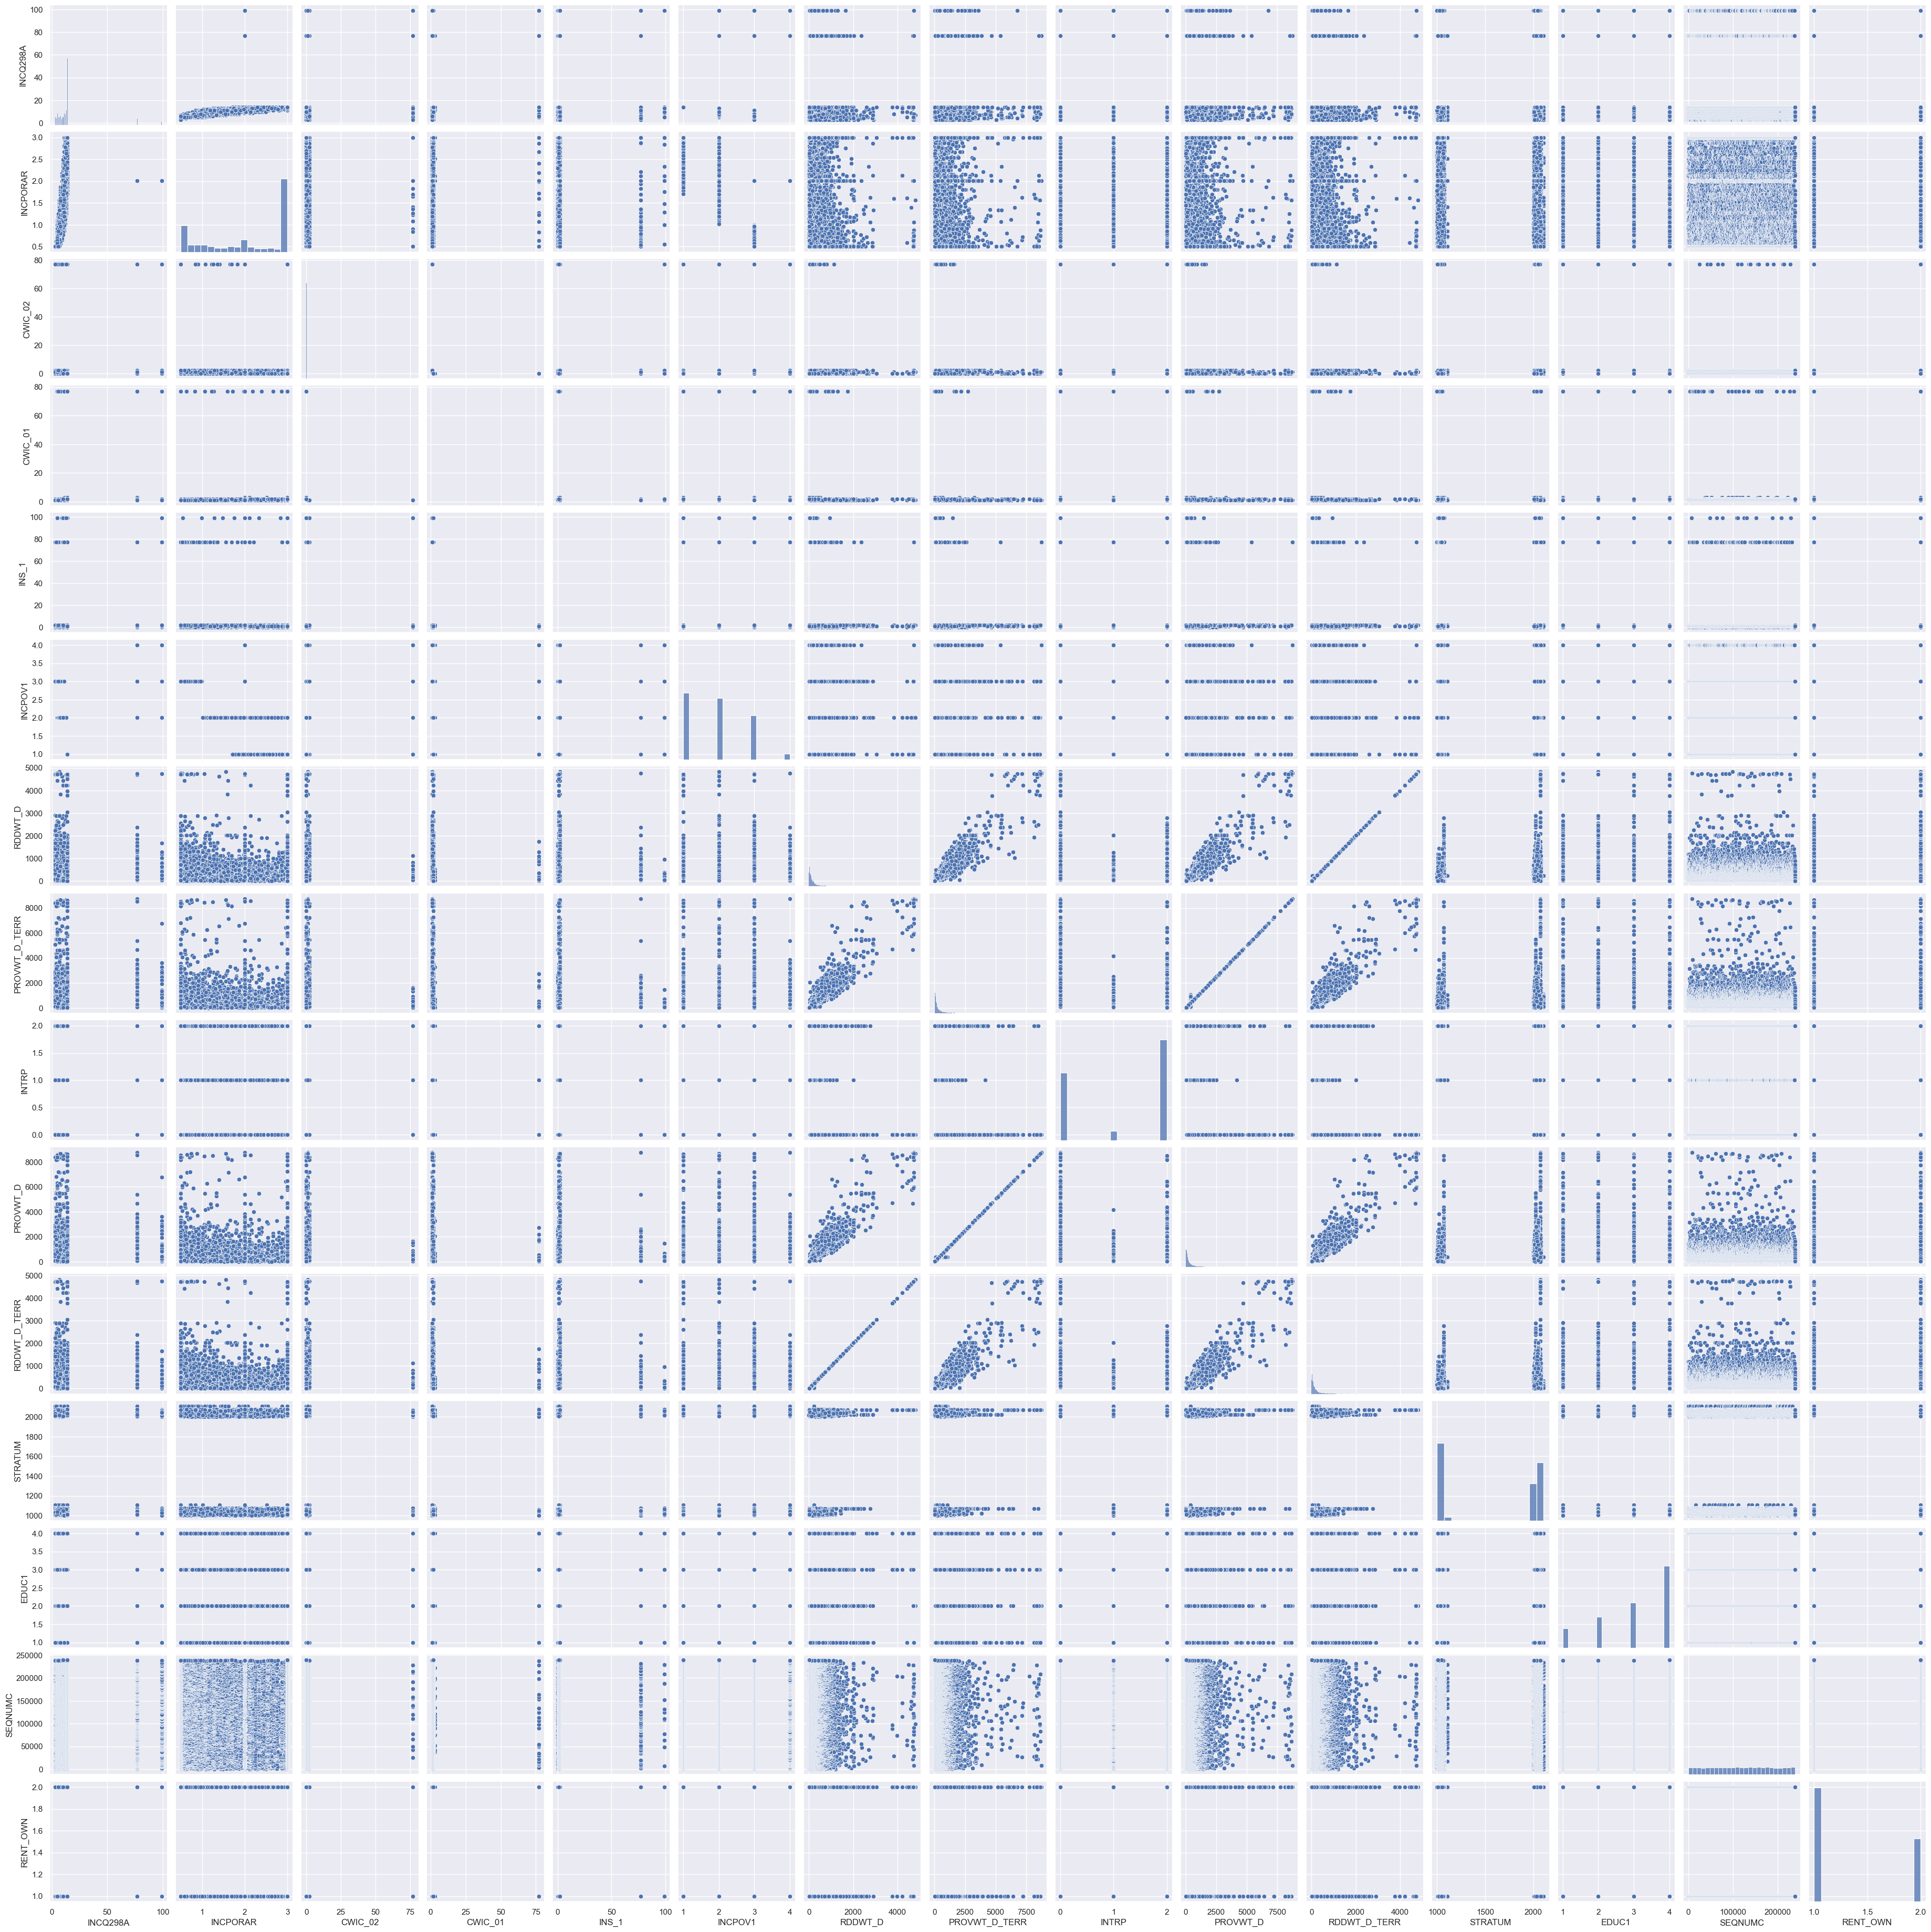

In [67]:
sns.pairplot(data=top_rank_df)

New Correlation Matrix of the data

<Axes: >

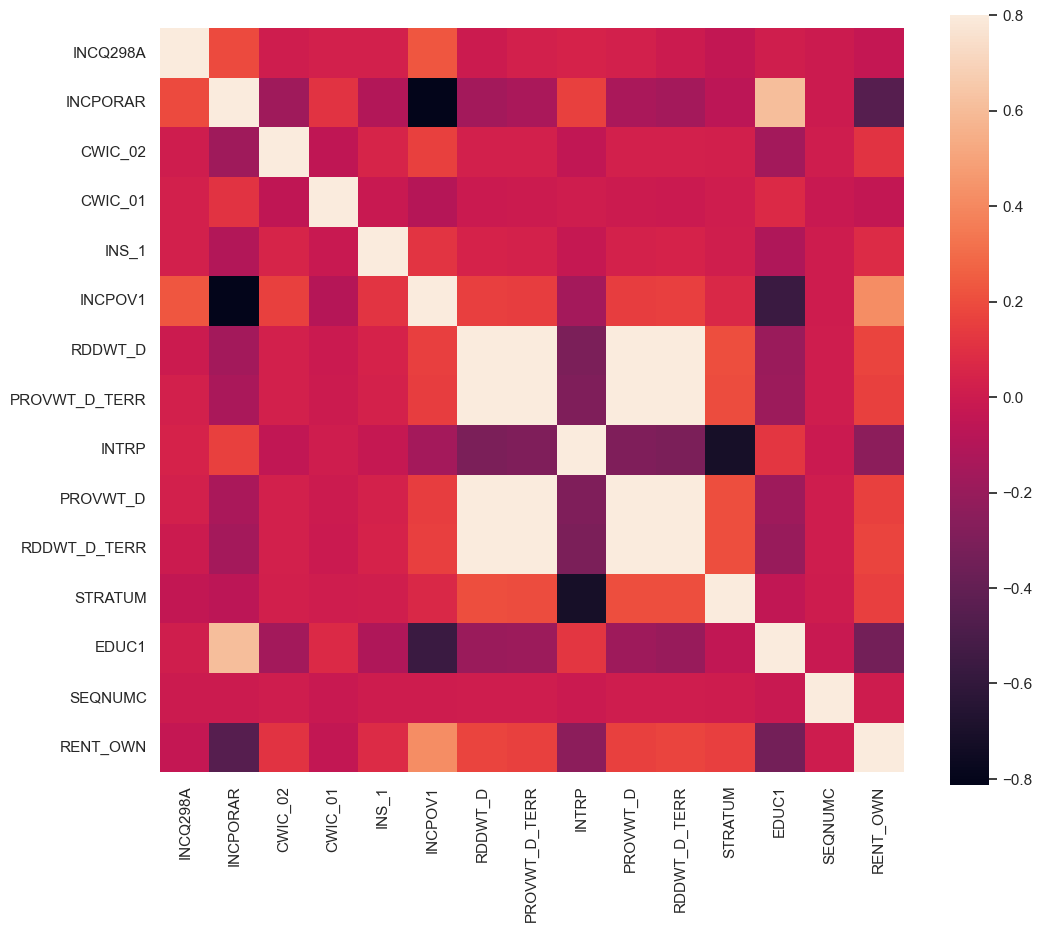

In [68]:
corrmat = top_rank_df.corr()
f, ax = plt.subplots(figsize=(12,10)) #setting some parameters of the plot to help readability
sns.heatmap(corrmat, vmax = .8, square=True)

Looking at the correlation plot, owning / renting a home are closely associated with income and education features.

In [69]:
y = top_rank_df.RENT_OWN
x = top_rank_df.drop(['RENT_OWN'], axis=1)

In [70]:
# Creating a 70/30 train test split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

clf=RandomForestClassifier(n_estimators=100)
clf.fit(x_train,y_train)

RandomForestClassifier()

In [71]:
y_pred=clf.predict(x_test)

In [72]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) 

Accuracy: 0.7555299539170507


Unfortunately the accuracy of the model is only 75%. I am going to take a look at a new variable, maritial status.

In [73]:
df_marital = df_full

In [74]:
y = df_marital.MARITAL2
x = df_marital.drop(['MARITAL2'], axis=1)

In [75]:
# Creating a 70/30 train test split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

clf=RandomForestClassifier(n_estimators=100)
clf.fit(x_train,y_train)

RandomForestClassifier()

In [76]:
y_pred=clf.predict(x_test)

In [77]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) 

Accuracy: 0.8488269145639663


All right, a model that gives an 85% accuracy. Let us see what the features are in the model.

In [78]:
# Creating the random number
np.random.seed(42)
x['random'] = np.random.normal(0.0, 1.0, size=x.shape[0])

C:\Users\matth\AppData\Local\Temp\ipykernel_18632\1480610971.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  x['random'] = np.random.normal(0.0, 1.0, size=x.shape[0])


In [79]:
# Checking that the random number was added
x.head(10)

SEQNUMC  SEQNUMHH  PDAT     PROVWT_D  PROVWT_D_TERR     RDDWT_D   
1        21         2     1   806.846012     806.846012  454.860417  \
3        41         4     1    63.448686      63.448686   36.965931   
4        51         5     1    94.872632      94.872632   64.620204   
5        52         5     1   152.273845     152.273845   85.219413   
6        61         6     1   210.186351     210.186351  112.170514   
7        71         7     1   204.953336     204.953336  142.607339   
8        81         8     1  1016.753531    1016.753531  499.775831   
11      111        11     1   390.532585     390.532585  177.088881   
12      121        12     1   248.745510     248.745510  171.865720   
13      131        13     1   489.064864     489.064864  396.329703   

    RDDWT_D_TERR  STRATUM  YEAR  AGECPOXR  ...  XVRCTY8  XVRCTY9  INS_1   
1     454.860417     2036  2014       0.0  ...      0.0      0.0    2.0  \
3      36.965931     2016  2014       0.0  ...      0.0      0.0    1.0   
4      64.620204     1073  2014       0.0  ...      0.0      0.0    2.0   
5      85.219413     1073  2014       0.0  ...      0.0      0.0    2.0   
6     112.170514     1057  2014       0.0  ...      0.0      0.0    2.0   
7     142.607339     2002  2014       0.0  ...      0.0      0.0    1.0   
8     499.775831     1022  2014       0.0  ...      0.0      0.0    1.0   
11    177.088881     2047  2014       0.0  ...      0.0      0.0    2.0   
12    171.865720     2016  2014       0.0  ...      0.0      0.0    2.0   
13    396.329703     2025  2014       0.0  ...      0.0      0.0    2.0   

    INS_2  INS_3  INS_3A  INS_4_5  INS_6  INS_11    random  
1     0.0    0.0     2.0      2.0    2.0     0.0  0.496714  
3     2.0    2.0     0.0      2.0    2.0     2.0 -0.138264  
4     1.0    1.0     0.0      2.0    2.0    77.0  0.647689  
5     1.0    1.0     0.0      2.0    2.0     1.0  1.523030  
6     0.0    0.0     1.0      2.0    2.0     2.0 -0.234153  
7     2.0    2.0     0.0      2.0    2.0     2.0 -0.234137  
8     0.0    0.0     2.0      2.0    2.0     2.0  1.579213  
11    0.0    0.0     1.0      2.0    2.0    77.0  0.767435  
12    1.0    2.0     0.0      2.0    2.0     2.0 -0.469474  
13    1.0    2.0     0.0      2.0    2.0     2.0  0.542560  

[10 rows x 461 columns]

In [80]:
# Creating a 70/30 train test split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

clf=RandomForestClassifier(n_estimators=100)
clf.fit(x_train,y_train)

RandomForestClassifier()

In [81]:
# Running the random forest
features = x_train.columns
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Save the feature ranking to a list for later use
# and print it on the screen

feature_rank = []
print("Feature ranking:")

for f in range(x_train.shape[1]):
    feature = f"{f + 1}. feature {features[indices[f]]}   \t{importances[indices[f]] * 100 :.2f}%"
    if 'random' in features[indices[f]]:
        feature += " <=="
    print(feature)
    feature_rank.append([features[indices[f]], importances[indices[f]]] )

Feature ranking:
1. feature INCQ298A   	4.49%
2. feature NUM_CELLS_PARENTS   	4.21%
3. feature INCPORAR   	3.56%
4. feature CWIC_02   	3.41%
5. feature CWIC_01   	3.28%
6. feature INS_1   	2.66%
7. feature EDUC1   	2.41%
8. feature C1R   	1.85%
9. feature C5R   	1.79%
10. feature M_AGEGRP   	1.73%
11. feature NUM_CELLS_HH   	1.69%
12. feature BF_ENDR06   	1.65%
13. feature INCPOV1   	1.47%
14. feature PROVWT_D_TERR   	1.18%
15. feature BF_FORMR08   	1.17%
16. feature RDDWT_D   	1.14%
17. feature RENT_OWN   	1.11%
18. feature PROVWT_D   	1.11%
19. feature RDDWT_D_TERR   	1.09%
20. feature INS_2   	1.00%
21. feature random   	1.00% <==
22. feature SEQNUMC   	0.99%
23. feature STRATUM   	0.99%
24. feature SEQNUMHH   	0.97%
25. feature ESTIAP14   	0.95%
26. feature INS_3A   	0.86%
27. feature EST_GRANT   	0.86%
28. feature DFLU1   	0.85%
29. feature RACE_K   	0.85%
30. feature DVRC1   	0.84%
31. feature DHEPB2   	0.84%
32. feature DPCV4   	0.83%
33. feature DDTP4   	0.83%
34. feature DHIB3

There are now 17 features that are better at predicting maritial status than a randomw number. Unfortunately some of them are things like, "Number of cell phones in the house", and "Number of cell phones parents have".

In [82]:
top_ranks = feature_rank[:17]
top_ranks

[['INCQ298A', 0.04493876505087042],
 ['NUM_CELLS_PARENTS', 0.04205578681194119],
 ['INCPORAR', 0.035614140113308386],
 ['CWIC_02', 0.034059552087169584],
 ['CWIC_01', 0.03281737474751377],
 ['INS_1', 0.026599281255561942],
 ['EDUC1', 0.024139091182115505],
 ['C1R', 0.018546259039010072],
 ['C5R', 0.017921462918803675],
 ['M_AGEGRP', 0.01726100006084509],
 ['NUM_CELLS_HH', 0.01690526401982556],
 ['BF_ENDR06', 0.016486299096405605],
 ['INCPOV1', 0.014730609307548475],
 ['PROVWT_D_TERR', 0.01182666975841087],
 ['BF_FORMR08', 0.011680061895478211],
 ['RDDWT_D', 0.01141982463766642],
 ['RENT_OWN', 0.011076082424101616]]

In [83]:
top_rank_cols = [s[0].split(',')[0] for s in top_ranks]
top_rank_cols.append('MARITAL2')
top_rank_cols

['INCQ298A',
 'NUM_CELLS_PARENTS',
 'INCPORAR',
 'CWIC_02',
 'CWIC_01',
 'INS_1',
 'EDUC1',
 'C1R',
 'C5R',
 'M_AGEGRP',
 'NUM_CELLS_HH',
 'BF_ENDR06',
 'INCPOV1',
 'PROVWT_D_TERR',
 'BF_FORMR08',
 'RDDWT_D',
 'RENT_OWN',
 'MARITAL2']

In [84]:
top_rank_df = df_marital[top_rank_cols].copy()

In [85]:
top_rank_df.head(10)

INCQ298A  NUM_CELLS_PARENTS  INCPORAR  CWIC_02  CWIC_01  INS_1  EDUC1   
1          4                2.0  0.500000      0.0        2    2.0      2  \
3         14                2.0  3.000000      0.0        2    1.0      4   
4          3                3.0  0.500000      1.0        1    2.0      2   
5          3                3.0  0.500000      1.0        1    2.0      2   
6          5                1.0  1.089867      1.0        1    2.0      3   
7         14                2.0  3.000000      0.0        2    1.0      4   
8         14                2.0  3.000000      0.0        2    1.0      4   
11        10                2.0  1.438797      0.0        2    2.0      3   
12         9                1.0  1.481544      1.0        1    2.0      3   
13         5                1.0  0.639352      1.0        1    2.0      2   

    C1R  C5R  M_AGEGRP  NUM_CELLS_HH   BF_ENDR06  INCPOV1  PROVWT_D_TERR   
1     6    1         2           2.0   91.312500        3     806.846012  \
3     4    1         3           2.0  334.812500        1      63.448686   
4     8    3         2           3.0  258.079564        3      94.872632   
5     8    3         2           3.0  258.079564        3     152.273845   
6     2    3         2           2.0  121.750000        2     210.186351   
7     3    2         3           2.0  273.937500        1     204.953336   
8     3    1         3           2.0  182.625000        1    1016.753531   
11    5    4         2           2.0  258.079564        2     390.532585   
12    4    1         2           1.0  334.812500        2     248.745510   
13    3    1         2           1.0  258.079564        3     489.064864   

    BF_FORMR08     RDDWT_D  RENT_OWN  MARITAL2  
1    91.312500  454.860417         2         1  
3   273.937500   36.965931         1         1  
4   320.905656   64.620204         2         1  
5   320.905656   85.219413         2         1  
6    91.312500  112.170514         1         2  
7   182.625000  142.607339         1         1  
8   182.625000  499.775831         1         1  
11  320.905656  177.088881         1         2  
12  888.000000  171.865720         2         1  
13  320.905656  396.329703         2         2

Marital Pair Plot

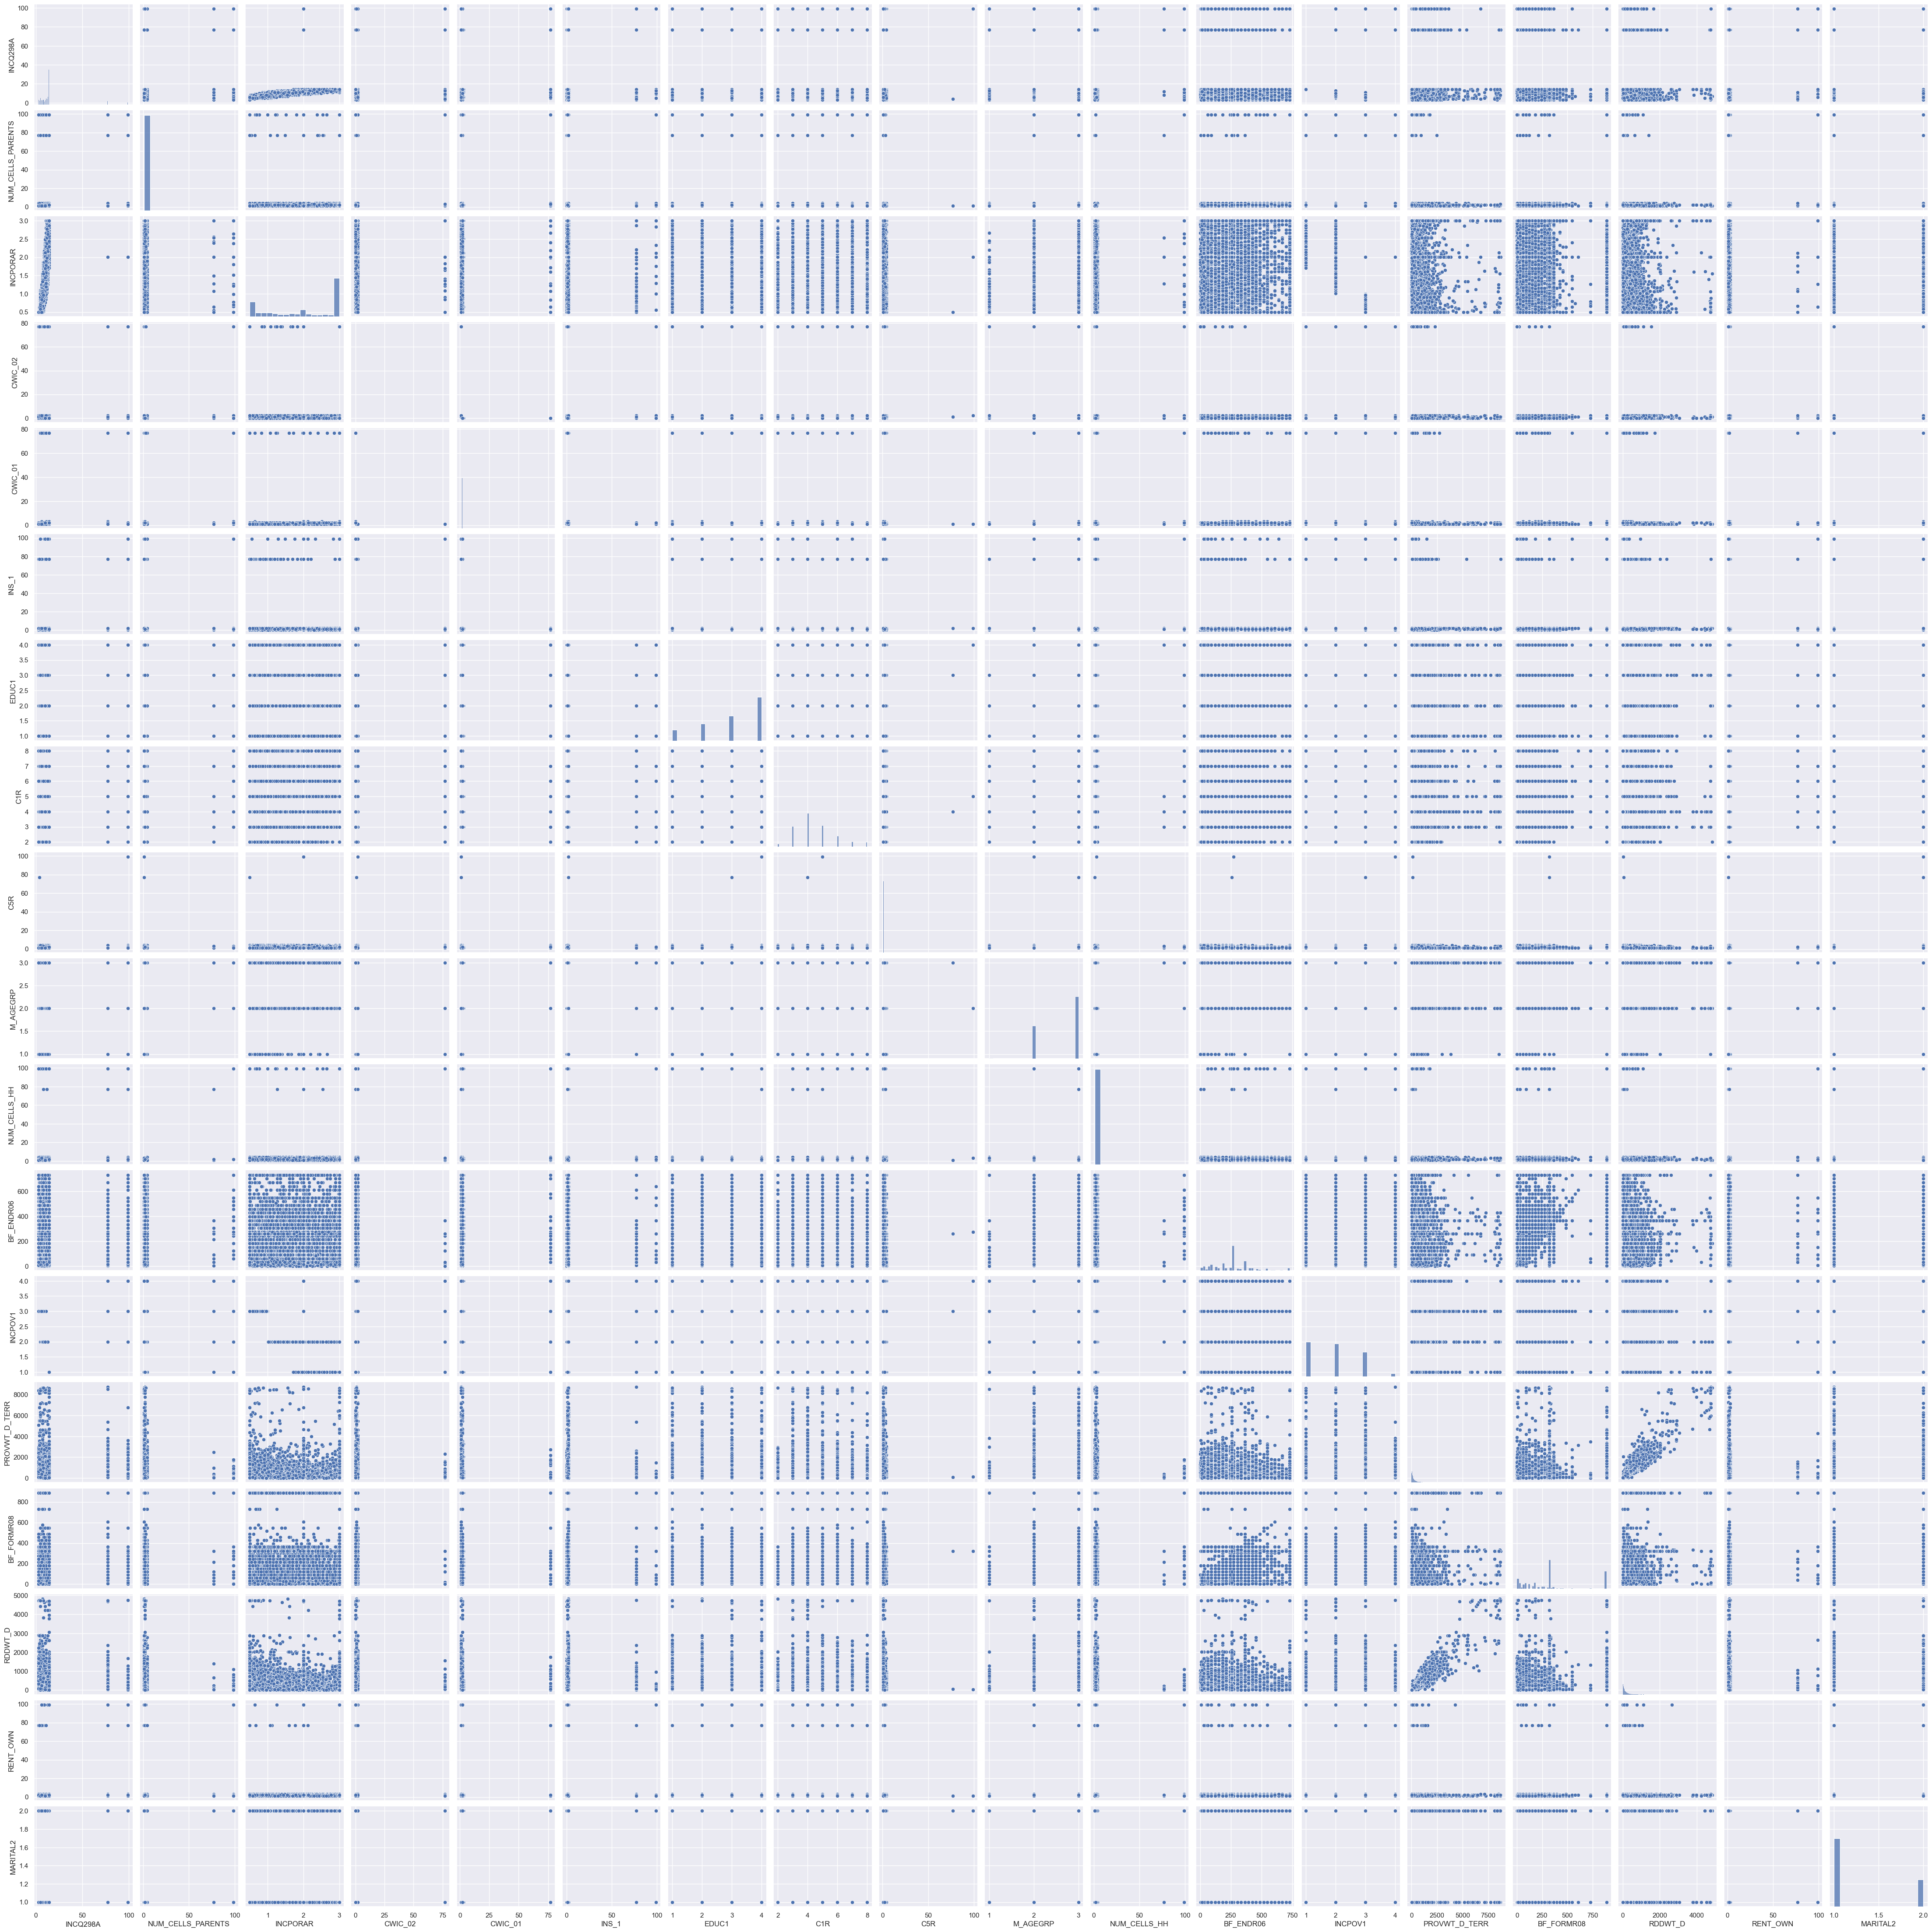

In [86]:
sns.pairplot(data=top_rank_df)

Marital Correlation Plot

<Axes: >

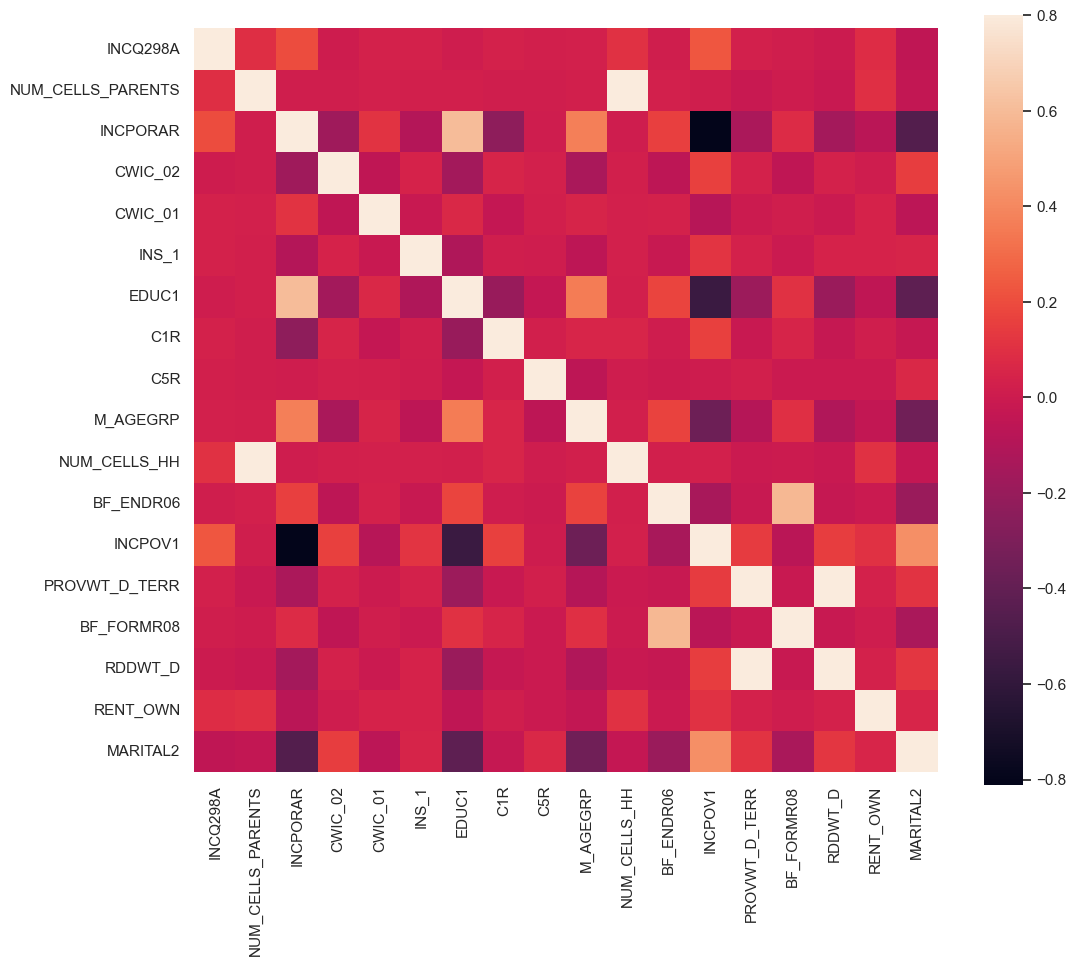

In [87]:
corrmat = top_rank_df.corr()
f, ax = plt.subplots(figsize=(12,10)) #setting some parameters of the plot to help readability
sns.heatmap(corrmat, vmax = .8, square=True)

It looks like the, wic benefits and poverty status, are positively correlated and the, income to poverty ratio, marital age group, and education, are negatively correlated with marital status.

In [89]:
marital = top_rank_df
marital.head(10)

INCQ298A  NUM_CELLS_PARENTS  INCPORAR  CWIC_02  CWIC_01  INS_1  EDUC1   
1          4                2.0  0.500000      0.0        2    2.0      2  \
3         14                2.0  3.000000      0.0        2    1.0      4   
4          3                3.0  0.500000      1.0        1    2.0      2   
5          3                3.0  0.500000      1.0        1    2.0      2   
6          5                1.0  1.089867      1.0        1    2.0      3   
7         14                2.0  3.000000      0.0        2    1.0      4   
8         14                2.0  3.000000      0.0        2    1.0      4   
11        10                2.0  1.438797      0.0        2    2.0      3   
12         9                1.0  1.481544      1.0        1    2.0      3   
13         5                1.0  0.639352      1.0        1    2.0      2   

    C1R  C5R  M_AGEGRP  NUM_CELLS_HH   BF_ENDR06  INCPOV1  PROVWT_D_TERR   
1     6    1         2           2.0   91.312500        3     806.846012  \
3     4    1         3           2.0  334.812500        1      63.448686   
4     8    3         2           3.0  258.079564        3      94.872632   
5     8    3         2           3.0  258.079564        3     152.273845   
6     2    3         2           2.0  121.750000        2     210.186351   
7     3    2         3           2.0  273.937500        1     204.953336   
8     3    1         3           2.0  182.625000        1    1016.753531   
11    5    4         2           2.0  258.079564        2     390.532585   
12    4    1         2           1.0  334.812500        2     248.745510   
13    3    1         2           1.0  258.079564        3     489.064864   

    BF_FORMR08     RDDWT_D  RENT_OWN  MARITAL2  
1    91.312500  454.860417         2         1  
3   273.937500   36.965931         1         1  
4   320.905656   64.620204         2         1  
5   320.905656   85.219413         2         1  
6    91.312500  112.170514         1         2  
7   182.625000  142.607339         1         1  
8   182.625000  499.775831         1         1  
11  320.905656  177.088881         1         2  
12  888.000000  171.865720         2         1  
13  320.905656  396.329703         2         2

<Axes: xlabel='MARITAL2', ylabel='NUM_CELLS_HH'>

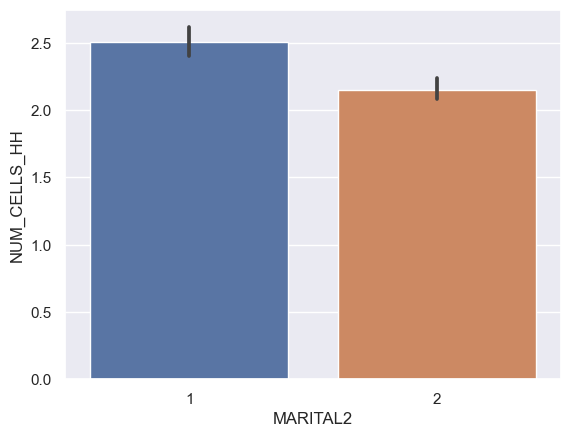

In [93]:
sns.barplot(x="MARITAL2", y="NUM_CELLS_HH", data=marital)

A look at number of cell phones compared to marital status. 1 is the married group, 2 is the not-married group. Bar in the confidence interval.

A look at income catagory compared to the years you have been married. This shows that the longer you have been married the higher your income is group.

<Axes: xlabel='INCQ298A', ylabel='M_AGEGRP'>

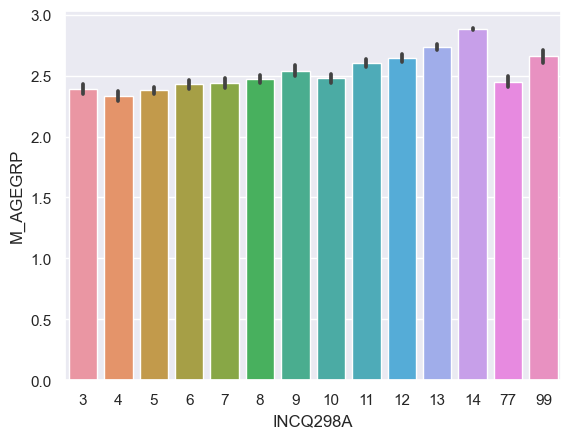

In [115]:
sns.barplot(x='INCQ298A', y='M_AGEGRP', data=marital)

A box plot of income to poverty ratio compated to Poverty status. Those in group 3 are Below the poverty line and have a very low income to poverty ratio.

<Axes: xlabel='INCPOV1', ylabel='INCPORAR'>

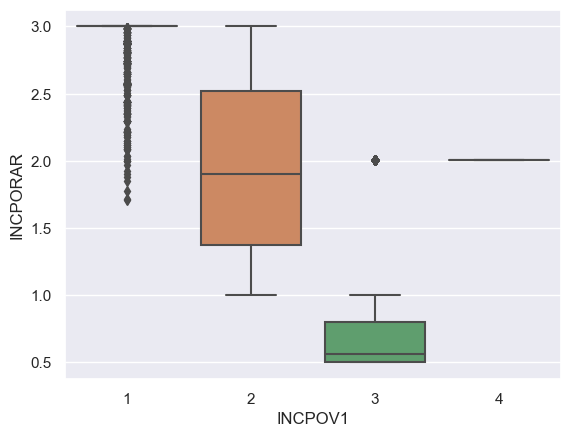

In [121]:
sns.boxplot(x='INCPOV1', y='INCPORAR', data = marital)

A look at the number of people in the household compared to poverty and marital status. Those who are Below Poverty Level (3) and married have the most people living in their houses. Those that are unmarried and above the poverty level, but below $75k a year, have the least amount of people living in their houses.

<Axes: xlabel='INCPOV1', ylabel='C1R'>

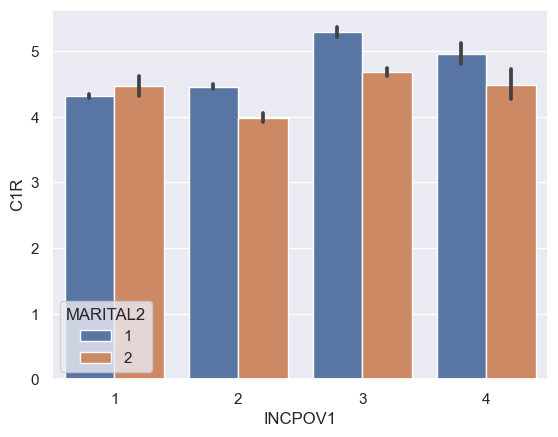

In [123]:
sns.barplot(x='INCPOV1',y='C1R', hue='MARITAL2', data=marital)

A look at education and poverty rate. Those with a 4 (College Grad) score the highest in each of the Income to poverty caragories.

<Axes: xlabel='INCPOV1', ylabel='INCPORAR'>

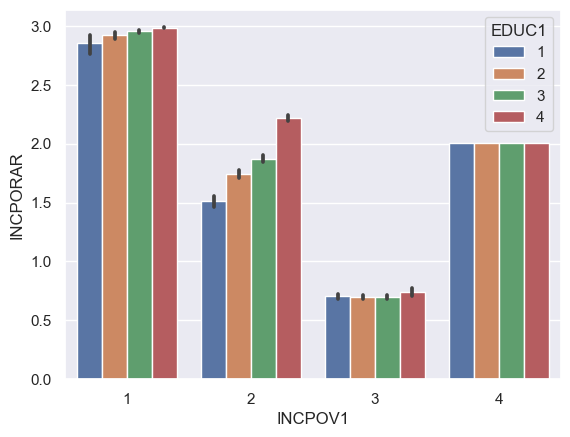

In [127]:
sns.barplot(x='INCPOV1',y='INCPORAR', hue='EDUC1', data=marital)

Dropping Varriables: Based on the sns plot and correlation martix several of the variables are going to be trimmed out due to having a low correlation. INCQ298A, the cell phone features, wic status, number of people in household C1R, and rent to own will all be dropped.

In [131]:
small_marital = marital.drop(['INCQ298A', 'NUM_CELLS_PARENTS', 'CWIC_01', 'C1R', 'NUM_CELLS_HH', 'RENT_OWN'], axis=1)

In [132]:
small_marital.head(5)

INCPORAR  CWIC_02  INS_1  EDUC1  C5R  M_AGEGRP   BF_ENDR06  INCPOV1   
1  0.500000      0.0    2.0      2    1         2   91.312500        3  \
3  3.000000      0.0    1.0      4    1         3  334.812500        1   
4  0.500000      1.0    2.0      2    3         2  258.079564        3   
5  0.500000      1.0    2.0      2    3         2  258.079564        3   
6  1.089867      1.0    2.0      3    3         2  121.750000        2   

   PROVWT_D_TERR  BF_FORMR08     RDDWT_D  MARITAL2  
1     806.846012   91.312500  454.860417         1  
3      63.448686  273.937500   36.965931         1  
4      94.872632  320.905656   64.620204         1  
5     152.273845  320.905656   85.219413         1  
6     210.186351   91.312500  112.170514         2

In [133]:
y = marital.MARITAL2
x = marital.drop(['MARITAL2'], axis=1)


In [134]:
# Creating a 70/30 train test split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

clf=RandomForestClassifier(n_estimators=100)
clf.fit(x_train,y_train)

RandomForestClassifier()

In [135]:
y_pred=clf.predict(x_test)

In [136]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) 

Accuracy: 0.8528109783089862


That slightly improved the model, by about 1%.

# Discussion / Conclusion

The biggest challenge in working with this dataset is the number of unknown values that it contained. I decided to start off by pairing down the data to just the rows that the paper said contained "Adequate Data". In retrospect this may not have been a good approach. When I started working I wanted to look at Chicken Pox and if it was affected by immunizations. I would have needed a data set that contained all the immunization information to have done so.

After running the random forest classifier with "Had Chicken Pox" as the target it was found that the data was unable to provide a good model, and that the strongest feature was at what age a child had had chicken pox.

I then repeated the random forest classifier with Owning or Renting a house, again the accuracy of the model was too low.

Finally I performed the random forest classifier with Marital Status as the target. This produced a model with 84.5% accuract using the 17 features that performed better than a random number. I paried this feature set down to 11 features which improved the models accuracy to 85.3%.

Visualization of model features is shown and includes the relationship between marital status and income, number of people living in the home, education, and poverty ratio.